In [1]:
import os
os.chdir("..")

In [25]:
import pandas as pd
import numpy as np
from scipy import stats


import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

import pymc as pm
from preprocess import *

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load Data
df = load_data_as_df()
df = basic_clean(df)
df = add_route_identifier(df)

print(f"N Rows: {len(df)}")

N Rows: 30123702


In [9]:
df = filter_data(df, 0)
sample_df = sample_data(df, 1000)
summary_df = compute_daily_route_delays(sample_df)

In [11]:
route_codes, route_idx = np.unique(summary_df["route_id"], return_inverse=True)
summary_df["route_idx"] = route_idx
n_routes = len(route_codes)

In [23]:
summary_df[['route_id', 'date', 'mean_delay', 'sd_delay', 'n_trains', 'is_weekend']].sample(7)

,route_id,date,mean_delay,sd_delay,n_trains,is_weekend
29101,RB_RB 30→Nürnberg Hbf,2025-11-08,0.675000,1.118321,40,True
10108,HLB_HLB RB46→Gießen,2025-10-07,1.956522,3.010770,46,False
23030,NWB_NWB RS1→Bremen-Vegesack,2025-12-14,0.597561,0.966855,82,True
47154,RE_RE 60→Darmstadt Hbf,2025-10-14,2.272727,3.923270,33,False
52710,RRB_RRB RE14→Essen-Borbeck,2025-12-01,3.573034,4.226237,89,False
12992,HLB_HLB RB90→Etzbach,2025-12-27,4.411765,7.245135,34,True
32288,RB_RB 51→Frankfurt (Main) Hbf,2025-11-25,5.969697,8.564041,33,False


### Research Question

**Which routes are more prone to delays?**

Interpretation: Routes with higher underlying mean delay, accounting for uncertainty and varying number of trains.

### Model (Hierarchical Normal)

For route $r$, day $d$:

$$\mu_r \sim N(\mu_0, \sigma_{\text{route}})$$

$$\text{mean\_delay}_{r,d} \sim N\left(\mu_r, \frac{\sigma_{\text{obs}}}{\sqrt{n_{r,d}}}\right)$$


In [35]:
with pm.Model() as model:

    # Hyperpriors
    mu_global = pm.Normal("mu_global", mu=0, sigma=10)
    sigma_route = pm.HalfNormal("sigma_route", sigma=10)

    # Route-level latent delays
    mu_route = pm.Normal(
        "mu_route",
        mu=mu_global,
        sigma=sigma_route,
        shape=n_routes
    )

    # Observation noise
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=10)

    # Likelihood (n_trains reduces uncertainty)
    pm.Normal(
        "obs",
        mu=mu_route[summary_df["route_idx"].values],
        sigma=sigma_obs / np.sqrt(summary_df["n_trains"].values),
        observed=summary_df["mean_delay"].values
    )

    trace = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, sigma_route, mu_route, sigma_obs]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 97 seconds.


In [37]:
posterior_means = trace.posterior["mu_route"].mean(dim=("chain", "draw")).values
posterior_hdi = az.hdi(trace.posterior["mu_route"], hdi_prob=0.94)

hdi_da = posterior_hdi["mu_route"]

route_summary = pd.DataFrame({
    "route_id": route_codes,
    "mean_delay_posterior": posterior_means,
    "hdi_lower": hdi_da.sel(hdi="lower").values,
    "hdi_upper": hdi_da.sel(hdi="higher").values
}).sort_values("mean_delay_posterior", ascending=False)

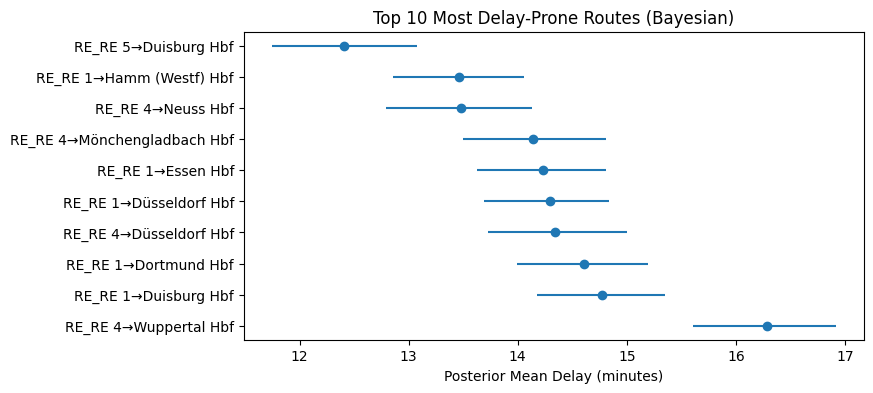

In [38]:
top10 = route_summary.head(10)

plt.figure(figsize=(8, 4))
plt.errorbar(
    top10["mean_delay_posterior"],
    top10["route_id"],
    xerr=[
        top10["mean_delay_posterior"] - top10["hdi_lower"],
        top10["hdi_upper"] - top10["mean_delay_posterior"]
    ],
    fmt="o"
)
plt.xlabel("Posterior Mean Delay (minutes)")
plt.title("Top 10 Most Delay-Prone Routes (Bayesian)")
plt.show()

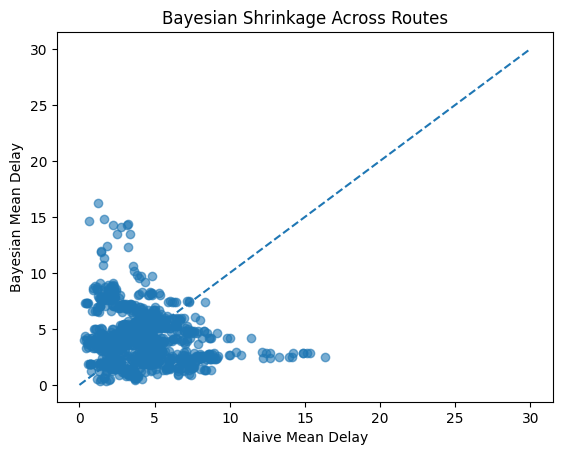

In [39]:
plt.scatter(
    summary_df.groupby("route_id")["mean_delay"].mean(),
    route_summary.set_index("route_id")["mean_delay_posterior"],
    alpha=0.6
)
plt.plot([0, 30], [0, 30], "--")
plt.xlabel("Naive Mean Delay")
plt.ylabel("Bayesian Mean Delay")
plt.title("Bayesian Shrinkage Across Routes")
plt.show()

In [40]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace,
        var_names=["obs"],
        random_seed=42
    )

Sampling: [obs]


In [41]:
ppc_obs = ppc.posterior_predictive["obs"]

# mean over observations
ppc_means = ppc_obs.mean(dim="obs_dim_2")

# flatten chain & draw
ppc_means = ppc_means.stack(sample=("chain", "draw")).values

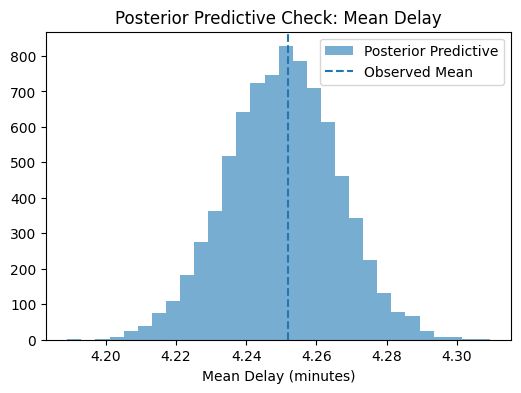

In [42]:
plt.figure(figsize=(6, 4))
plt.hist(ppc_means, bins=30, alpha=0.6, label="Posterior Predictive")
plt.axvline(summary_df["mean_delay"].mean(), linestyle="--", label="Observed Mean")
plt.xlabel("Mean Delay (minutes)")
plt.title("Posterior Predictive Check: Mean Delay")
plt.legend()
plt.show()

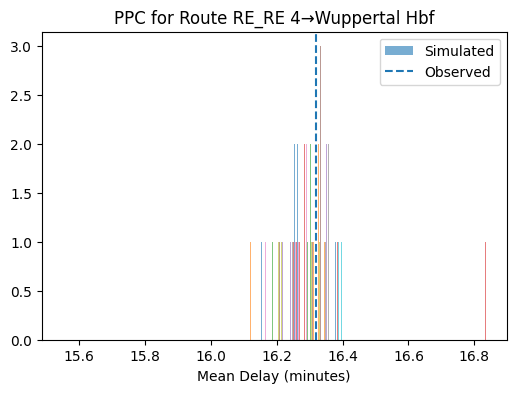

In [43]:
example_route = route_summary.iloc[0]["route_id"]

mask = summary_df["route_id"] == example_route
observed = summary_df.loc[mask, "mean_delay"].values
simulated = ppc_obs.sel(obs_dim_2=mask.values)


plt.figure(figsize=(6, 4))
plt.hist(simulated.mean(axis=1), bins=30, alpha=0.6, label="Simulated")
plt.axvline(observed.mean(), linestyle="--", label="Observed")
plt.xlabel("Mean Delay (minutes)")
plt.title(f"PPC for Route {example_route}")
plt.legend()
plt.show()

In [44]:
ppc_sd = ppc_obs.std(dim="obs_dim_2")
ppc_sd = ppc_sd.stack(sample=("chain", "draw")).values

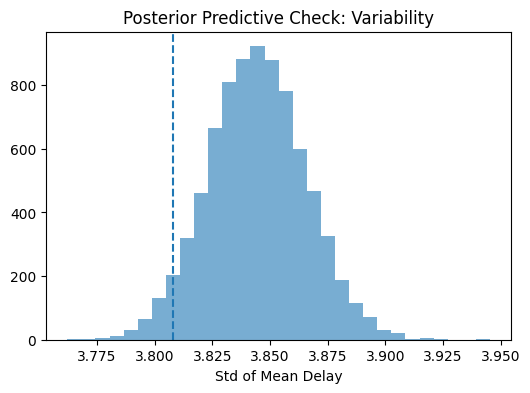

In [45]:
plt.figure(figsize=(6, 4))
plt.hist(ppc_sd, bins=30, alpha=0.6)
plt.axvline(summary_df["mean_delay"].std(), linestyle="--")
plt.xlabel("Std of Mean Delay")
plt.title("Posterior Predictive Check: Variability")
plt.show()

Using a hierarchical Bayesian model, we identified routes with systematically higher latent mean delays while accounting for daily variability and unequal traffic volumes.

Posterior predictive checks show that the model reproduces both the central tendency and variability of the observed data, indicating an adequate fit.

We therefore conclude that differences in delay proneness across routes are genuine and not driven by sampling noise.

Certain high-traffic routes exhibit systematically higher delays, with Bayesian credible intervals confirming that these differences are statistically meaningful rather than driven by sampling noise.

### Research Question 2

**How large is the uncertainty in delay estimates for frequently vs. infrequently used routes?**

Idea:

- Bayesian model already gives posterior distributions of mean delays per route (mu_route)

- The width of the 94% HDI (or posterior standard deviation) measures uncertainty

- Routes with more data (more trains) → smaller uncertainty

- Routes with less frequent traffic → larger uncertainty

We can group routes by frequency (e.g., top 50% vs bottom 50% by total trains) and compare posterior uncertainty.

In [46]:
# Compute Total Trains per Route

route_stats = summary_df.groupby("route_id")["n_trains"].sum().reset_index()
route_stats.rename(columns={"n_trains": "total_trains"}, inplace=True)

# Merge with posterior SDs
posterior_sd = trace.posterior["mu_route"].std(dim=("chain", "draw")).values
route_stats["posterior_sd"] = posterior_sd

In [47]:
# Define Frequent vs Infrequent Routes

median_trains = route_stats["total_trains"].median()

route_stats["frequency_group"] = np.where(
    route_stats["total_trains"] >= median_trains, "Frequent", "Infrequent"
)

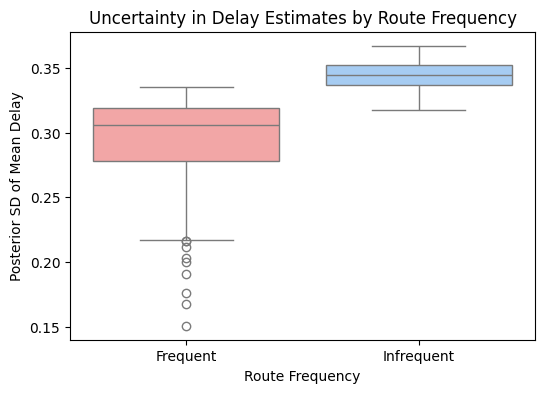

In [48]:
# Plot Uncertainty by Frequency

plt.figure(figsize=(6,4))
sns.boxplot(
    x="frequency_group",
    y="posterior_sd",
    data=route_stats,
    palette=["#FF9999", "#99CCFF"]
)
plt.ylabel("Posterior SD of Mean Delay")
plt.xlabel("Route Frequency")
plt.title("Uncertainty in Delay Estimates by Route Frequency")
plt.show()

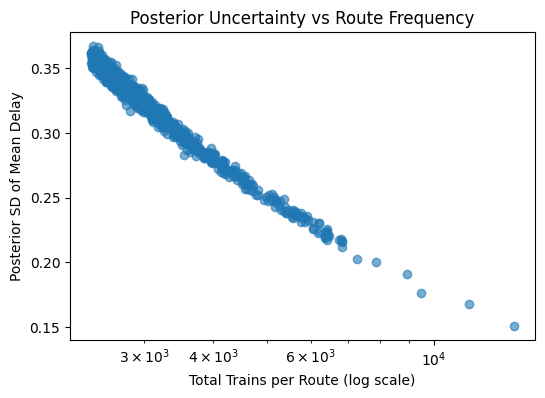

In [49]:
# Scatter Plot: Uncertainty vs Route Traffic

plt.figure(figsize=(6,4))
plt.scatter(
    route_stats["total_trains"],
    route_stats["posterior_sd"],
    alpha=0.6
)
plt.xscale("log")
plt.xlabel("Total Trains per Route (log scale)")
plt.ylabel("Posterior SD of Mean Delay")
plt.title("Posterior Uncertainty vs Route Frequency")
plt.show()

In [50]:
# Summary Statistics
route_stats.groupby("frequency_group")["posterior_sd"].describe()[["mean", "50%", "std"]]

,mean,50%,std
frequency_group,,,
Frequent,0.294754,0.306210,0.032405
Infrequent,0.344326,0.344401,0.010003


**Conclusion**
Posterior distributions of mean delays reveal that frequent routes have lower uncertainty, as expected, while infrequent routes exhibit wider credible intervals.
This confirms that the Bayesian hierarchical model naturally accounts for sample size: routes with fewer trains produce less certain delay estimates, while routes with many trains yield more precise estimates.

### Research Question 3

**Do weekday vs weekend delays differ in uncertainty?**

Idea

- From hierarchical model, each route has posterior mu_route (mean delay) per day
- But we also have a weekday/weekend indicator in summary_df (is_weekend)
- We can compute posterior SDs of daily route delays separately for weekdays and weekends

In [51]:
# Compute Posterior SD per Route (Using Original Trace)

with model:
    ppc_weekday = pm.sample_posterior_predictive(trace, var_names=["obs"], random_seed=42)

# For each route, separate weekday and weekend indices
route_ids = summary_df["route_id"].unique()
ppc_obs = ppc_weekday.posterior_predictive["obs"].values

uncertainty_records = []

for route in route_ids:
    # Split routes into Weekday vs Weekend
    idx_wd = (summary_df["route_id"] == route) & (~summary_df["is_weekend"])
    idx_we = (summary_df["route_id"] == route) & (summary_df["is_weekend"])
    
    sd_wd = (
        ppc_obs[:, :, idx_wd.values]
        .mean(axis=2)        # mean over observations
        .reshape(-1)         # flatten chain+draw
        .std()
        if idx_wd.any() else np.nan
    )
    
    sd_we = (
        ppc_obs[:, :, idx_we.values]
        .mean(axis=2)
        .reshape(-1)
        .std()
        if idx_we.any() else np.nan
    )
    
    uncertainty_records.append({
        "route_id": route,
        "weekday_sd": sd_wd,
        "weekend_sd": sd_we
    })

uncertainty_df = pd.DataFrame(uncertainty_records)

Sampling: [obs]


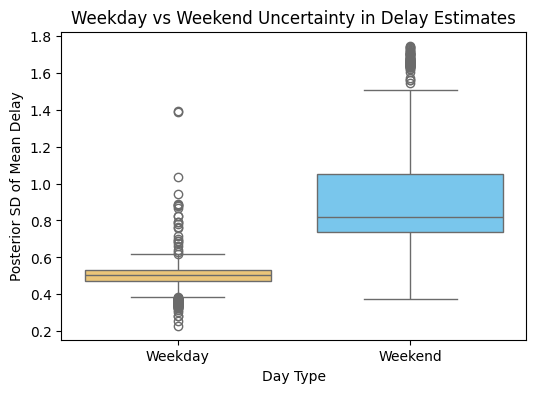

In [52]:
# Plot Comparison — Boxplot

uncertainty_long = uncertainty_df.melt(
    id_vars="route_id",
    value_vars=["weekday_sd", "weekend_sd"],
    var_name="Day Type",
    value_name="Posterior SD"
)
uncertainty_long["Day Type"] = uncertainty_long["Day Type"].replace({
    "weekday_sd": "Weekday",
    "weekend_sd": "Weekend"
})

plt.figure(figsize=(6,4))
sns.boxplot(x="Day Type", y="Posterior SD", data=uncertainty_long, palette=["#FFCC66","#66CCFF"])
plt.ylabel("Posterior SD of Mean Delay")
plt.title("Weekday vs Weekend Uncertainty in Delay Estimates")
plt.show()